In [2]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt

import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns


In [3]:
sns.set_theme(style="ticks")

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

$$

a \in \mathbb{R}^{2}\\
b \in \mathbb{R}^{2 \times i}\\
x_t^{tr} \in \mathbb{R}^{i \times 1}\\
x_t^{em} \in \mathbb{R}^{j \times 1}\\

c \in \mathbb{R}^{K}\\



a \sim \mathcal{N}(0, 1)\\ 
b \sim \mathcal{N}(0, 1)\\


\alpha_t = a + b \cdot x_{t}^{tr} \\

\pi_t \sim Dirichlet(\alpha_t)\\

z_t \sim Categorical(\pi_t)\\

y_t \sim VonMises(y_t | x_{t}^{em} \cdot c_{z_t}, \kappa_{z_t})

$$

In [4]:
# Example shapes for demonstration
S, T = 312, 120

# Suppose x_tr and x_em are given:
# x_tr with shape (S, T, 3)
# x_em with shape (S, T, 1)
# obs: The observed data, shape (S, T)
# For demonstration, we simulate some random data:
rng = np.random.default_rng(seed=42)
x_tr = rng.normal(size=(S, T, 3))
x_em = rng.normal(size=(S, T, 1))
obs = rng.normal(0, 1, size=(S, T))  # Example observed data

with pm.Model() as model:
    # Define global parameters
    a = pm.Normal('a', mu=0, sigma=1, shape=2)          # shape: (2,)
    b = pm.Normal('b', mu=0, sigma=1, shape=(2, 3))     # shape: (2, 3)

    # Additional parameters for emission distribution
    c = pm.Normal('c', mu=0, sigma=1, shape=2)          # shape: (2,)
    kappa = pm.Exponential('kappa', 1, shape=2)         # shape: (2,)

    # Calculate alpha for Dirichlet parameters
    # alpha_t = a + b · x_tr
    alpha = pm.Deterministic('alpha', a[None, None, :] + pm.math.sum(b[None, None, :, :] * x_tr, axis=-1))
    # alpha shape: (S, T, 2)

    # Ensure alpha is positive for Dirichlet parameters using exponential
    alpha_positive = pm.Deterministic('alpha_positive', pm.math.exp(alpha))

    # Define Dirichlet distribution for transition probabilities
    pi = pm.Dirichlet('pi', a=alpha_positive, shape=(S, T, 2))

    # Define categorical latent states based on transition probabilities
    z = pm.Categorical('z', p=pi, shape=(S, T))

    # Define emission means using x_em, c, and latent states z
    # y_t ~ VonMises(y_t | x_em * c[z_t], kappa[z_t])
    y_mean = pm.Deterministic('y_mean', x_em[..., 0] * c[z])
    # y_mean shape: (S, T)

    # Observed data using the VonMises distribution
    y_obs = pm.VonMises('y_obs', mu=y_mean, kappa=kappa[z], observed=obs)

    # Sample from the posterior
    trace = pm.sample(1000, return_inferencedata=True)


ValueError: Incompatible Elemwise input shapes [(1, 1, 2, 3), (1, 312, 120, 3)]

In [ ]:
# Define constants
S, T = 312, 120
wmu = pt.as_tensor_variable([0, 4])

# Generate synthetic data
rng = np.random.default_rng()
latents = rng.binomial(1, 0.6, S*T).reshape(S, T)
obs = np.where(latents == 1, rng.normal(0, 1, (S, T)), rng.normal(4, 1, (S, T)))

with pm.Model() as model:
    # Define shared priors
    # a = pm.Normal('a', mu=0, sigma=1, shape=(S, 1))  # Shape (2,) for two latent states
    # b = pm.Normal('b', mu=0, sigma=1, shape=(T, 1))  # Shape (2, T) to match trials

    # Observed data input
    y = pm.Data('y', obs)

    # (312 x 120) .  (120 x 1) + (312 x 1)
    # alpha = obs @ b + a
    alpha = [0.5, 0.5]

    # Define the Dirichlet and Categorical latent process
    pi = pm.Dirichlet('pi', a=alpha, shape=(S, T, 2))  # Shape (S, T, 2) for pi
    z = pm.Categorical('z', p=pi, shape=(S, T))  # Latent states over (S, T)

    # Define observed variable with a normal distribution based on latent states
    y_obs = pm.Normal('y_obs', mu=wmu[z], sigma=1, observed=y)

    # Sampling
    trace = pm.sample(1000, return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [pi]
>BinaryGibbsMetropolis: [z]


Output()

In [3]:
S = 312
T = 120

latents = rng.binomial(1, 0.6, S*T).reshape(S, T)

obs = np.zeros((S, T))

for i in range(S):
    for j in range(T):
        if latents[i, j] == 1:
            obs[i,j] += rng.normal(0, 1)
        else:
            obs[i,j] += rng.normal(4, 1)

In [4]:
wmu = pt.as_tensor_variable([0, 4])
z = pt.as_tensor_variable(np.zeros(shape=(S, T)))
pi = pt.as_tensor_variable(np.zeros(shape=(S, T)))

with pm.Model() as model:
    
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)

    y = pm.Data('y', obs)


    for s in range(S):

        z[s, 0].set( pm.Categorical('z0', p=[0.5, 0.5]) )
        pi[s, 0].set( pm.Dirichlet('pi0', a=[0.5, 0.5]) )

        for t in range(T):

            y_obs = pm.Normal('y_obs', mu=wmu[z[s,t]], sigma=1, observed=y[s, t])

            if t < T-1:
                alpha = a + b * obs[s, t]
                pi[s, t] = pm.Dirichlet('pi', a=alpha)
                z[s, t+1].set( pm.Categorical(f'z{s}{t}', p=pi[s, t]) )

with model:
    trace = pm.sample(1000, return_inferencedata=True)


TypeError: Trying to increment a 0-dimensional subtensor with a 1-dimensional value.

array([[<Axes: title={'center': 'prob_prior'}>,
        <Axes: title={'center': 'prob_prior'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>]],
      dtype=object)

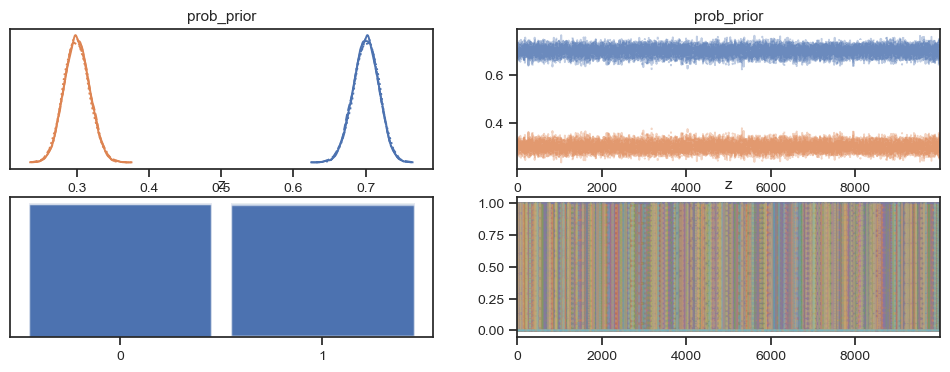

In [ ]:
az.plot_trace(trace)

In [ ]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [ ]:
trace.posterior["z"].values.shape

(4, 10000, 1000)

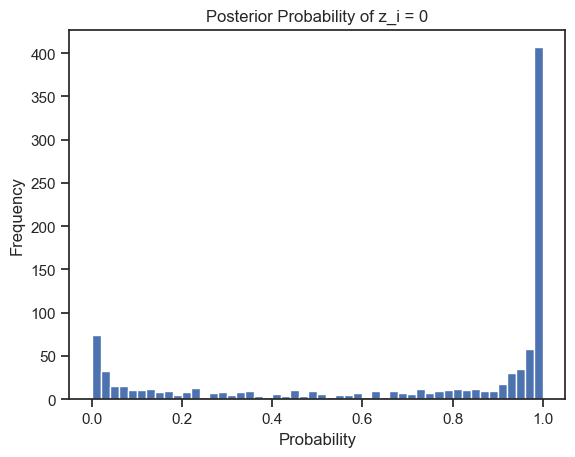

In [ ]:
import numpy as np

# Extract samples
posterior = trace.posterior
z_samples = posterior['z'].values  # shape: (chains, draws, N)

# Calculate the posterior probability for z_i = 0
p_z0 = (z_samples == 0).mean(axis=(0, 1))

# Similarly for z_i = 1
p_z1 = (z_samples == 1).mean(axis=(0, 1))

# Now you can plot p_z0 or p_z1
import matplotlib.pyplot as plt

plt.hist(p_z0, bins=50)
plt.title('Posterior Probability of z_i = 0')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()


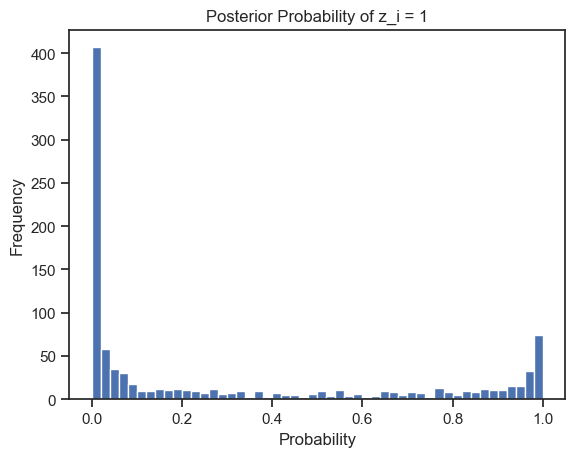

In [ ]:
# Now you can plot p_z0 or p_z1
import matplotlib.pyplot as plt

plt.hist(p_z1, bins=50)
plt.title('Posterior Probability of z_i = 1')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()


In [ ]:
p_z0.mean(), p_z1.mean()

(0.70074965, 0.29925035)

In [ ]:
# Dummy data placeholders
time, states = 100, 2 
tr_predictors, em_predictors = 3, 1
em_output = 1

u_tr =  rng.normal(size=(time, tr_predictors))
u_em = rng.normal(size=(time))
y = rng.vonmises(2.5, 1, size=(time))

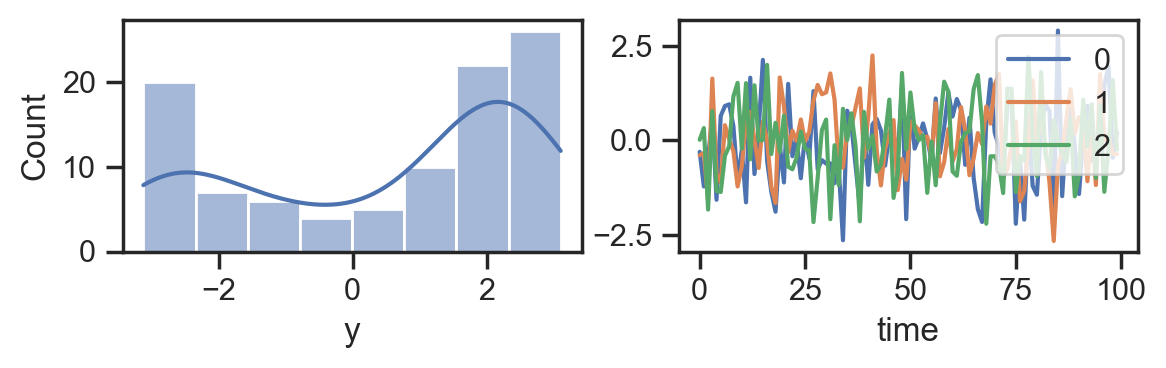

In [ ]:
# Make 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi = 200)

sns.histplot(
    y, 
    ax=axs[0], 
    kde=True,
    stat="count",
).set_xlabel("y")

sns.lineplot(
    data=u_tr,
    ax=axs[1],
    dashes=False,
).set_xlabel("time")

plt.tight_layout()
plt.show()